In [15]:
import mujoco
import mujoco_viewer
import matplotlib.pyplot as plt
import numpy as np
import os
from lxml import etree
import mujoco.viewer
import time

In [16]:
f1 = "/Users/nikita/Documents/Учеба/ИМРС/simrobs_group_2025/SRS/practice_3/examples/4bar.xml"
f2 = "/Users/nikita/Documents/Учеба/ИМРС/simrobs_group_2025/SRS/practice_3/examples/4bar_modified.xml"

# Функция заменяет для указанного пути xml параметры аттрибутов через
# расположение xml / тип элемента / имя элемента / имя атрибута элемента
# и перезаписывает аттрибут на новый, сохраняет ноый xml файл

# The function replaces attribute parameters for the specified xml path by
# xml location / element type / element name / element attribute name
# and overwrites the attribute with the new attribute, saves the new xml file

def swap_par(tree, element_type, element_name, attribute_name, new_value):   
    # Находим тип и имя элемента, в котором меняем аттрибут
    # Find the type and name of the element in which we change the attribute
    
    element = tree.find(f'.//{element_type}[@name="{element_name}"]')
    
    # Меняем аттрибут
    # Change the attribute
    element.set(attribute_name, new_value)

In [17]:
L_AB = 100e-3
L_BC = 2.5 * L_AB
L_DC = 2.5 * L_AB
L_AD = 2 * L_AB
L_CP = 2.5 * L_AB

h = 1.5 # height of the mechanism for debugging

# Парсим текущий xml из указанного расположения
# Parses the current xml from the specified location
tree = etree.parse(f1)

swap_par(tree, 'geom', 'link AB', 'pos', f"0 -{L_AB/2} 0")
swap_par(tree, 'geom', 'link AB', 'size', f"0.015 {L_AB/2}")

swap_par(tree, 'body', 'BC1P', 'pos', f"0 -{L_AB} 0")
swap_par(tree, 'geom', 'link BC', 'pos', f"0 -{L_BC/2} 0")
swap_par(tree, 'geom', 'link BC', 'size', f"0.015 {L_BC/2}")
swap_par(tree, 'site', 'sC1', 'pos', f"0 -{L_BC} 0")

swap_par(tree, 'body', 'CP', 'pos', f"0 -{L_BC} 0")
swap_par(tree, 'geom', 'link CP', 'pos', f"0 -{L_CP/2} 0")
swap_par(tree, 'geom', 'link CP', 'size', f"0.015 {L_CP/2}")
swap_par(tree, 'site', 'sP', 'pos', f"0 -{L_CP} 0")

swap_par(tree, 'body', 'DC2', 'pos', f"{L_AD} 0 1.5")
swap_par(tree, 'geom', 'link DC', 'pos', f"0 -{L_DC/2} 0")
swap_par(tree, 'geom', 'link DC', 'size', f"0.015 {L_DC/2}")
swap_par(tree, 'site', 'sC2', 'pos', f"0 -{L_DC} 0")

# Create new xml
tree.write(f2, pretty_print=True, xml_declaration=True, encoding='UTF-8')


In [18]:
model = mujoco.MjModel.from_xml_path(f2)
data = mujoco.MjData(model)

def set_torque(mj_data, KP, KV, theta):
    data.ctrl[0] = KP * (-mj_data.qpos[0] + theta) + KV * (0 - mj_data.qvel[0])

SIMEND = 20
TIMESTEP = 0.001
STEP_NUM = int(SIMEND / TIMESTEP)
timeseries = np.linspace(0, SIMEND, STEP_NUM)

T = 2 # [s]
FREQ = 1/T # [Hz]
AMP = np.deg2rad(-90) # [rad]
BIAS = np.deg2rad(-90) # [rad]

theta_des = AMP * np.sin(FREQ * timeseries) + BIAS

EE_position_x = []
EE_position_z = []

In [19]:
viewer = mujoco_viewer.MujocoViewer(model, 
                                    data, 
                                    title="4bar", 
                                    width=1920, 
                                    height=1080)

for i in range(STEP_NUM):  
    if viewer.is_alive:     
        set_torque(data, 20, 5, theta_des[i])
        
        position_EE = data.site_xpos[1]
        EE_position_x.append(position_EE[0])
        EE_position_z.append(position_EE[2])
        
        mujoco.mj_step(model, data)
        viewer.render()

    else:
        break
viewer.close()

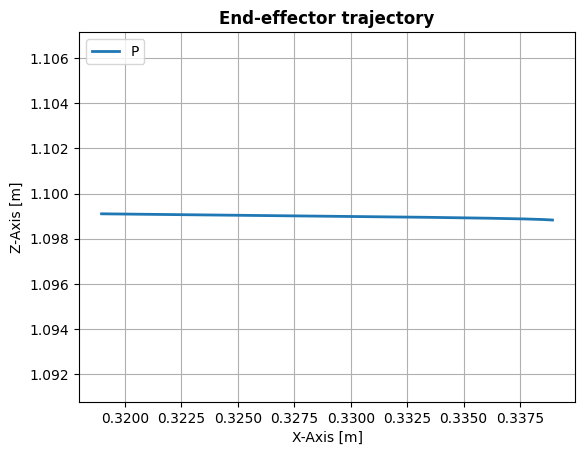

In [20]:
midlength = int(STEP_NUM/2)

plt.clf()
plt.plot(EE_position_x[midlength:], EE_position_z[midlength:], '-', linewidth=2, label='P')
plt.title('End-effector trajectory', fontsize=12, fontweight='bold')
plt.legend(loc='upper left')
plt.xlabel('X-Axis [m]')
plt.ylabel('Z-Axis [m]')
plt.axis('equal')
plt.grid()
plt.draw()

In [21]:
h_z = 1.1 # [m]
error = sum((EE_position_z[midlength:] - h_z * np.ones(midlength)) ** 2)/midlength
print(error)

ValueError: operands could not be broadcast together with shapes (1082,) (10000,) 

### Mechanism synthesis

In [12]:
from scipy.optimize import minimize

In [13]:
# error of mechanism trajectory position
def fourbar(X):

    L_AB = X[0]
    L_BC = X[1]
    L_DC = X[2]
    L_AD = X[3]
    L_CP = X[4]
        
    tree = etree.parse(f1)

    swap_par(tree, 'geom', 'link AB', 'pos', f"0 -{L_AB/2} 0")
    swap_par(tree, 'geom', 'link AB', 'size', f"0.015 {L_AB/2}")

    swap_par(tree, 'body', 'BC1P', 'pos', f"0 -{L_AB} 0")
    swap_par(tree, 'geom', 'link BC', 'pos', f"0 -{L_BC/2} 0")
    swap_par(tree, 'geom', 'link BC', 'size', f"0.015 {L_BC/2}")
    swap_par(tree, 'site', 'sC1', 'pos', f"0 -{L_BC} 0")

    swap_par(tree, 'body', 'CP', 'pos', f"0 -{L_BC} 0")
    swap_par(tree, 'geom', 'link CP', 'pos', f"0 -{L_CP/2} 0")
    swap_par(tree, 'geom', 'link CP', 'size', f"0.015 {L_CP/2}")
    swap_par(tree, 'site', 'sP', 'pos', f"0 -{L_CP} 0")

    swap_par(tree, 'body', 'DC2', 'pos', f"{L_AD} 0 1.5")
    swap_par(tree, 'geom', 'link DC', 'pos', f"0 -{L_DC/2} 0")
    swap_par(tree, 'geom', 'link DC', 'size', f"0.015 {L_DC/2}")
    swap_par(tree, 'site', 'sC2', 'pos', f"0 -{L_DC} 0")

    tree.write(f2, pretty_print=True, xml_declaration=True, encoding='UTF-8')

    tree = []

    model = mujoco.MjModel.from_xml_path(f2)
    data = mujoco.MjData(model)
    
    EE_position_x = []
    EE_position_z = []
    
    def set_torque(mj_data, KP, KV, theta):
        data.ctrl[0] = KP * (-mj_data.qpos[0] + theta) + KV * (0 - mj_data.qvel[0])
    
    
    if vis == True:
        
        viewer = mujoco_viewer.MujocoViewer(model, 
                                        data, 
                                        title="4bar", 
                                        width=640, 
                                        height=480)
    

        for i in range(STEP_NUM):  
            if viewer.is_alive:
        
                set_torque(data, 20, 5, theta_des[i])
        
                position_EE = data.site_xpos[1]
                EE_position_x.append(position_EE[0])
                EE_position_z.append(position_EE[2])
        
                mujoco.mj_step(model, data)
            
                viewer.render()                

            else:
                break
        viewer.close()
        
    else:
        for i in range(STEP_NUM):    
              
            set_torque(data, 20, 5, theta_des[i])
    
            position_EE = data.site_xpos[1]
            EE_position_x.append(position_EE[0])
            EE_position_z.append(position_EE[2])
    
            mujoco.mj_step(model, data)
              

  

    error = sum((EE_position_z[midlength:] - h_z * np.ones(midlength)) ** 2)/midlength
    return error


In [14]:
L_AB_init = 100e-3 # X[0]
L_BC_init = 2.5 * L_AB_init # X[1]
L_DC_init = 2.5 * L_AB_init # X[2]
L_AD_init = 2 * L_AB_init # X[3]
L_CP_init = 2.5 * L_AB_init # X[4]

X_init = np.array([L_AB_init, 
                   L_BC_init,
                   L_DC_init,
                   L_AD_init,
                   L_CP_init])

bnds = [(0.02, 0.4),
        (0.02, 0.4),
        (0.02, 0.4),
        (0.02, 0.4),
        (0.02, 0.4)]

opts = {'fatol': 1e-7, 'maxiter': 100}

constraints = [
    {'type': 'eq', 'fun': lambda vars: 2.5 * vars[0] - vars[1]},  # 2.5 * X[0] - X[1] = 0
    {'type': 'eq', 'fun': lambda vars: 2.5 * vars[0] - vars[2]},  # 2.5 * X[0] - X[2] = 0
    {'type': 'eq', 'fun': lambda vars: 2 * vars[0] - vars[3]},  # 2 * X[0] - X[3] = 0
    {'type': 'eq', 'fun': lambda vars: 2.5 * vars[0] - vars[4]}  # 2.5 * X[0] - X[4] = 0
]


In [15]:
h_z = 0.98
vis = True

result = minimize(fourbar, 
                  X_init, 
                  method='Nelder-Mead', 
                  bounds=bnds,
                  options=opts,
                  constraints=constraints)

C:\Users\earak\AppData\Local\Temp\ipykernel_17528\2390568476.py:4: RuntimeWarning: Method Nelder-Mead cannot handle constraints.
  result = minimize(fourbar,


KeyboardInterrupt: 

In [ ]:
print(f"X = {result.x}")
print(f"error = {result.fun}")

In [ ]:
X = result.x
vis = True

L_AB = X[0]
L_BC = X[1]
L_DC = X[2]
L_AD = X[3]
L_CP = X[4]
    
tree = etree.parse(f1)

swap_par(tree, 'geom', 'link AB', 'pos', f"0 -{L_AB/2} 0")
swap_par(tree, 'geom', 'link AB', 'size', f"0.015 {L_AB/2}")

swap_par(tree, 'body', 'BC1P', 'pos', f"0 -{L_AB} 0")
swap_par(tree, 'geom', 'link BC', 'pos', f"0 -{L_BC/2} 0")
swap_par(tree, 'geom', 'link BC', 'size', f"0.015 {L_BC/2}")
swap_par(tree, 'site', 'sC1', 'pos', f"0 -{L_BC} 0")

swap_par(tree, 'body', 'CP', 'pos', f"0 -{L_BC} 0")
swap_par(tree, 'geom', 'link CP', 'pos', f"0 -{L_CP/2} 0")
swap_par(tree, 'geom', 'link CP', 'size', f"0.015 {L_CP/2}")
swap_par(tree, 'site', 'sP', 'pos', f"0 -{L_CP} 0")

swap_par(tree, 'body', 'DC2', 'pos', f"{L_AD} 0 1.5")
swap_par(tree, 'geom', 'link DC', 'pos', f"0 -{L_DC/2} 0")
swap_par(tree, 'geom', 'link DC', 'size', f"0.015 {L_DC/2}")
swap_par(tree, 'site', 'sC2', 'pos', f"0 -{L_DC} 0")

tree.write(f2, pretty_print=True, xml_declaration=True, encoding='UTF-8')

tree = []

model = mujoco.MjModel.from_xml_path(f2)
data = mujoco.MjData(model)

EE_position_x = []
EE_position_z = []

viewer = mujoco_viewer.MujocoViewer(model, 
                                data, 
                                title="4bar", 
                                width=640, 
                                height=480)

def set_torque(mj_data, KP, KV, theta):
    data.ctrl[0] = KP * (-mj_data.qpos[0] + theta) + KV * (0 - mj_data.qvel[0])

for i in range(STEP_NUM):  
    if viewer.is_alive:
    
        set_torque(data, 20, 5, theta_des[i])
    
        position_EE = data.site_xpos[1]
        EE_position_x.append(position_EE[0])
        EE_position_z.append(position_EE[2])
    
        mujoco.mj_step(model, data)
        
        if vis == True:
            viewer.render()                

    else:
        break
viewer.close()

midlength = int(STEP_NUM/2)

plt.clf()
plt.plot(EE_position_x[midlength:], EE_position_z[midlength:], '-', linewidth=2, label='P')
plt.title('End-effector trajectory', fontsize=12, fontweight='bold')
plt.legend(loc='upper left')
plt.xlabel('X-Axis [m]')
plt.ylabel('Z-Axis [m]')
plt.axis('equal')
plt.grid()
plt.draw()